C:\Users\Apurk\AppData\Local\Temp\ipykernel_8292\1082306912.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2019-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed



Model Accuracy: 0.5290102389078498

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.91      0.66       148
           1       0.61      0.14      0.22       145

    accuracy                           0.53       293
   macro avg       0.56      0.53      0.44       293
weighted avg       0.56      0.53      0.45       293


Model saved at: ../models/trend_model.pkl


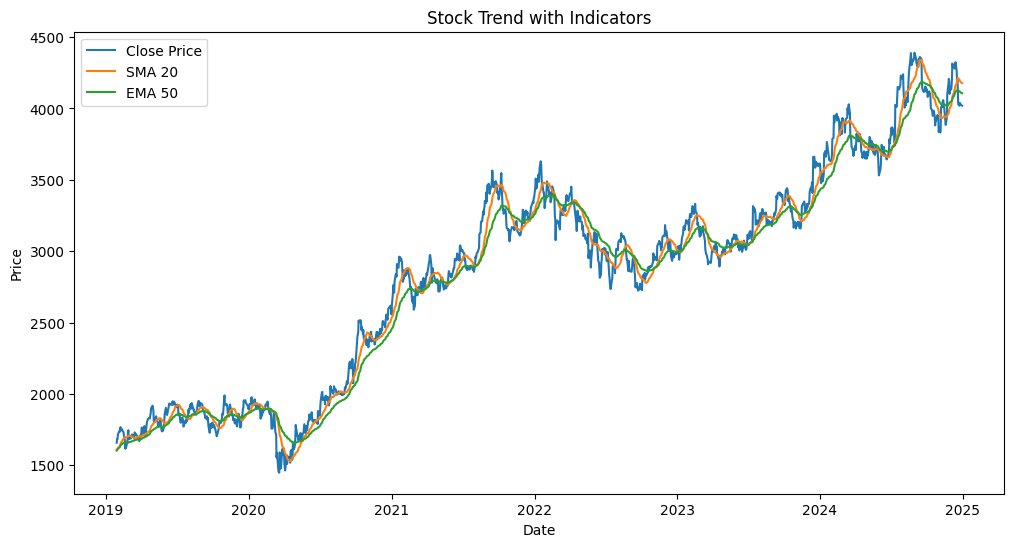


✅ PIPELINE COMPLETED SUCCESSFULLY


In [2]:
# ===============================
# STOCK TREND PREDICTION SYSTEM
# Single-Cell End-to-End Pipeline
# ===============================

# ---------- 1. IMPORT LIBRARIES ----------
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# ---------- 2. DOWNLOAD STOCK DATA ----------
ticker = "TCS.NS"
df = yf.download(ticker, start="2019-01-01", end="2024-12-31")

df.reset_index(inplace=True)

# ---------- 3. FEATURE ENGINEERING ----------
# Moving Averages
df["SMA_20"] = df["Close"].rolling(window=20).mean()
df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()
df["EMA_50"] = df["Close"].ewm(span=50, adjust=False).mean()

# RSI
delta = df["Close"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df["RSI"] = 100 - (100 / (1 + rs))

# MACD
ema_12 = df["Close"].ewm(span=12, adjust=False).mean()
ema_26 = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"] = ema_12 - ema_26
df["Signal_Line"] = df["MACD"].ewm(span=9, adjust=False).mean()

# ---------- 4. TARGET CREATION ----------
# 1 = Buy, 0 = Sell
df["Target"] = np.where(df["Close"].shift(-1) > df["Close"], 1, 0)

# ---------- 5. DATA CLEANING ----------
df.dropna(inplace=True)

# ---------- 6. FEATURES & LABEL ----------
features = [
    "SMA_20", "EMA_20", "EMA_50",
    "RSI", "MACD", "Signal_Line", "Volume"
]

X = df[features]
y = df["Target"]

# ---------- 7. TRAIN TEST SPLIT ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ---------- 8. MODEL TRAINING ----------
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

model.fit(X_train, y_train)

# ---------- 9. MODEL EVALUATION ----------
y_pred = model.predict(X_test)

print("\nModel Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ---------- 10. SAVE MODEL ----------
model_path = "../models/trend_model.pkl"
joblib.dump(model, model_path)
print(f"\nModel saved at: {model_path}")

# ---------- 11. VISUALIZATION ----------
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["Close"], label="Close Price")
plt.plot(df["Date"], df["SMA_20"], label="SMA 20")
plt.plot(df["Date"], df["EMA_50"], label="EMA 50")
plt.title("Stock Trend with Indicators")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

print("\n✅ PIPELINE COMPLETED SUCCESSFULLY")
